In this notebook i will start testing some of teh discoveries that i made in the EDA
For my first prediciton I will apply these ideas:
- District_price is a good feature
- Building_id is good ofr traning set, but not for test
- Lets just leave most missing values and let lightGBM use them
- Categorical features will be dealt with through lightGBM
- Will do one prediciton focusing on few, but important features
- And one with more features
- remove outliers from training data

In [69]:
from sklearn.model_selection import train_test_split
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from moscow_housing.display_data import import_data
import lightgbm as lgb

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#defien functions
def add_radius(df):
    #adds radius column to dataframe
    df['radius'] = np.sqrt((df['latitude']-55.75)**2 + (df['longitude']-37.55)**2)
    return df

def group_by_feature_and_price(df, feature, data_train = pd.DataFrame()):
    #makes a new column with the mean price for each group to all rows
    if data_train.empty:
        grouped = df.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price_y']
    else:
        grouped = data_train.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price']
    return df



#import data
#import the data and test data, set y values for both sets
data_train, data_test = import_data()

test_id = data_test.id
#lets first add radius

data_train = add_radius(data_train)
data_test = add_radius(data_test)

data_test._set_value(23,'radius',0.203899)
data_test._set_value(90,'radius',0.203899)
data_test._set_value(2511,'radius',0.218159)
data_test._set_value(5090,'radius',0.218159)
data_test._set_value(6959,'radius',0.218159)
data_test._set_value(8596,'radius',0.218159)
data_test._set_value(4719, 'radius',0.19580)
data_test._set_value(9547, 'radius',0.19520)
data_test._set_value(2529, 'radius', np.sqrt((37.464994-37.55)**2+(55.627666-55.75)**2))

#drop 4 largest from tranining data to get better things
data_train = data_train.drop([3217,21414,15840,13938])
Y= data_train.price

#Then we group by and add district price
data_train = group_by_feature_and_price(data_train,'district')
data_test = group_by_feature_and_price(data_test, 'district', data_train=data_train)

#add top floor variable
data_train['high_up'] = data_train.floor/data_train.stories
data_test['high_up'] = data_test.floor/data_test.stories
data_train['high_up'].where(data_train['high_up'] > 1, 1)
data_test['high_up'].where(data_test['high_up'] >= 1, 1)

#add own bathroom boolean
data_train['own_bathroom'] = data_train['bathrooms_private'].apply(lambda row: float('NaN') if pd.isnull(row)  else ( float(0) if row==0 else float(1)))
data_test['own_bathroom'] = data_test['bathrooms_private'].apply(lambda row: float('NaN') if pd.isnull(row)  else ( float(0) if row==0 else float(1)))

#then we chose which features to focus on
data_train_focus = data_train[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor','high_up','district_price','radius','rooms','area_total']]
data_test_focus = data_test[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor' ,'high_up','district_price','radius','rooms','area_total']]

#try with fewer attributes
data_train_focus = data_train[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor','high_up','district_price','radius','rooms','area_total']]
data_test_focus = data_test[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor' ,'high_up','district_price','radius','rooms','area_total']]


data_test_focus.info()
data_train_focus.info()

#determine which features is categorical
catergorical = ['parking', 'new', 'condition']
#'area_kitchen','area_living','bathrooms_shared','bathrooms_private','balconies','loggias'

#lets make the lightgbm model

#frist we should test it on the training set:
X_train, X_test, y_train, y_test = train_test_split(data_train_focus, Y, test_size=0.2, random_state=42)

lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=(0,1,2,3,4,5,6,7),
    num_leaves=256,
    max_depth=8,
    random_state=42,
    metric='rmsle',
    num_iterations=2000,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)

lightGBM_model.fit(X_train,y_train,categorical_feature=(0,1,2,3,4,5,6,7))
result = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

prediction = result.copy()

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nreal price: ',data_train.loc[[count]].price, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_train.loc[[count]])
    count += 1

rmsle = root_mean_squared_log_error(y_test,prediction)
print("first run", rmsle)

prediction = result.copy()

lightGBM_model.fit(data_train_focus,Y,categorical_feature=(0,1,2,3,4,5,6,7))
prediction = lightGBM_model.predict(data_test_focus)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_test_focus.loc[[count]])
    count += 1

submission = pd.DataFrame()
submission['id'] = test_id
submission['price_prediction'] = prediction

submission.to_csv('submission_lightGBM_EDA.csv', index= False)

In [70]:
#import synthetical data
synthethic_data = pd.read_csv('min_data_syntetisk_2.csv')
synthethic_data = synthethic_data.replace('*',float('NaN'))

synthethic_data = synthethic_data.astype(float)
synthethic_data['high_up'] = synthethic_data.floor/data_train.stories
synthethic_data['high_up'].where(data_train['high_up'] > 1, 1)

#try with fewer attributes
#best so far
data_train_focus = data_train[['district','condition','floor','high_up','radius','rooms','area_total','constructed','parking','new']]
data_test_focus = data_test[['district','condition','floor','high_up','radius','rooms','area_total','constructed','parking','new']]

#data to be merged with synthehtic
#all_data = pd.concat([data_train,synthethic_data])
#all_data.info()
#Y = all_data.price

#all_data_focus = data_train[['area_total','floor','rooms','radius','new','district','high_up']]
#data_test_focus = data_test[['area_total','floor','rooms','radius','new','district','high_up']]


data_test_focus.info()
data_test_focus.info()

#determine which features is categorical
catergorical = ['parking', 'new', 'condition']
#'area_kitchen','area_living','bathrooms_shared','bathrooms_private','balconies','loggias'

#lets make the lightgbm model

#frist we should test it on the training set:
X_train, X_test, y_train, y_test = train_test_split(data_train_focus,Y, test_size=0.2, random_state=42)

lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=(0,1,2,8,9,7),
    num_leaves=256,
    max_depth=8,
    random_state=42,
    metric='rmsle',
    num_iterations=1000,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district     9912 non-null   float64
 1   condition    5978 non-null   float64
 2   floor        9937 non-null   float64
 3   seller       5995 non-null   float64
 4   high_up      9937 non-null   float64
 5   radius       9937 non-null   float64
 6   rooms        9937 non-null   float64
 7   area_total   9937 non-null   float64
 8   constructed  9563 non-null   float64
 9   parking      7070 non-null   float64
 10  new          9828 non-null   float64
dtypes: float64(11)
memory usage: 854.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district     9912 non-null   float64
 1   condition    5978 non-null   float64
 2   floor        9937 non-nu

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_feature in param dict is overridden.
  _log_warning('{} in p

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

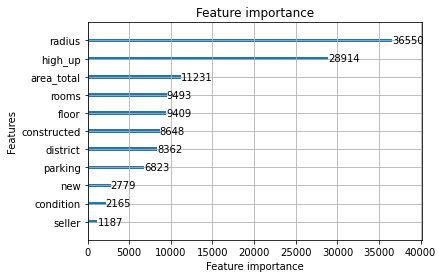

In [71]:
lightGBM_model.fit(X_train,np.log10(y_train),categorical_feature=(0,1,2,8,9,7))
result = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

In [72]:
prediction = result.copy()

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nreal price: ',data_train.loc[[count]].price, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_train.loc[[count]])
    count += 1

rmsle = root_mean_squared_log_error(y_test,10**prediction)
print("first run", rmsle)

first run 0.17648864069846623


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


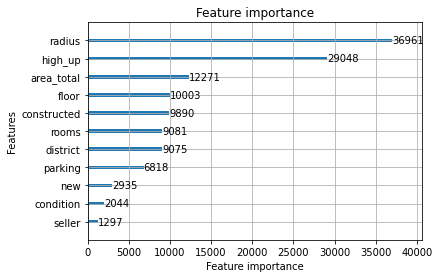

In [73]:
prediction = result.copy()

lightGBM_model.fit(data_train_focus,np.log10(Y),categorical_feature=(0,1,2,8,9,7))
prediction = lightGBM_model.predict(data_test_focus)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_test_focus.loc[[count]])
    count += 1

submission = pd.DataFrame()
submission['id'] = test_id
submission['price_prediction'] = 10**prediction

submission.to_csv('submission_lightGBM_EDA.csv', index= False)